In [2]:
import os
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
device = torch.device("cuda")

In [3]:
def dataset_x(path,data_augmentaion=False):
    pics = os.listdir(path)
    pics_list=[]
    if(data_augmentaion==True):
        for pic in pics:
            img = cv.imread(path+'/'+pic)
            #img = cv.resize(img, (32, 32))
            img = np.array(img)
            img = img/255
            flip_img = np.array(cv.flip(img, 1))
            flip_img=flip_img/255
            equ_img = cv.equalizeHist(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
            equ_img=np.array(cv.cvtColor(equ_img,cv.COLOR_GRAY2BGR))
            equ_img=equ_img/255
            pics_list.append(img)
            pics_list.append(flip_img)
            pics_list.append(equ_img)
    else:
        for pic in pics:
            img = cv.imread(path+'/'+pic)
            img = cv.resize(img, (32, 32))
            img = np.array(img)
            img = img/255
            pics_list.append(img)
    x = torch.Tensor(np.array(pics_list)).permute(0,3,1,2)
    return x

def dataset_y(dataset_x,type):
    size = dataset_x.shape[0]
    y = type*torch.ones([size])
    return y

train_empty_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/train/empty')
train_people_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/train/people')
train_train_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/train/train')
val_empty_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/val/empty')
val_people_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/val/people')
val_train_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/val/train')
test_empty_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/test/empty')
test_people_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/test/people')
test_train_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/test/train')
train_empty_y = dataset_y(train_empty_x,0)
train_people_y = dataset_y(train_people_x,1)
train_train_y = dataset_y(train_train_x,2)
val_empty_y = dataset_y(val_empty_x,0)
val_people_y = dataset_y(val_people_x,1)
val_train_y = dataset_y(val_train_x,2)
test_empty_y = dataset_y(test_empty_x,0)
test_people_y = dataset_y(test_people_x,1)
test_train_y = dataset_y(test_train_x,2)

In [4]:
import torch.utils.data as Data
batch_size = 48# 将训练数据的特征和标签组合
train_dataset = Data.TensorDataset(train_empty_x,train_empty_y)+Data.TensorDataset(train_people_x,train_people_y)+Data.TensorDataset(train_train_x,train_train_y)
val_dataset = Data.TensorDataset(val_empty_x,val_empty_y)+Data.TensorDataset(val_train_x,val_train_y)+Data.TensorDataset(val_people_x,val_people_y)
test_dataset = Data.TensorDataset(test_empty_x,test_empty_y)+Data.TensorDataset(test_people_x,test_people_y)+Data.TensorDataset(test_train_x,test_train_y)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
val_iter = Data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_iter = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [12]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.features= nn.Sequential(
            nn.Conv2d(kernel_size=3,in_channels=3,out_channels=96,stride=4,padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),

            nn.Conv2d(kernel_size=5,in_channels=96,out_channels=256,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),

            nn.Conv2d(kernel_size=3,in_channels=256,out_channels=384,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(kernel_size=3,in_channels=384,out_channels=384,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),            
        )
        self.classifier = nn.Sequential(
            nn.Linear(384,4096),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.Dropout(),
            nn.Linear(4096,3)
        )


    def forward(self,X):
        feature = self.features(X)
        out = F.avg_pool2d(feature,feature.shape[2])
        out = out.squeeze()
        out = self.classifier(out)
        return out

In [6]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

In [7]:
def train(net,train_iter,val_iter,loss,num_epochs,optimizer):
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
        if(val_acc>0.99):
            torch.save(net.state_dict(), 'output/alexnet.pth')
            return train_loss,val_loss,train_accuracy,val_accuracy
    return train_loss,val_loss,train_accuracy,val_accuracy

In [8]:
import matplotlib.pyplot as plt
import numpy as np
def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()    
    plt.show()

In [9]:
num_epochs=50
lr=0.01
loss=nn.CrossEntropyLoss()

In [13]:
net = AlexNet()
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [14]:
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_iter,val_iter,loss,num_epochs,optimizer)

epoch1,loss0.1670,train acc 0.784000,val acc 0.707
epoch2,loss0.0182,train acc 0.837464,val acc 0.730
epoch3,loss0.0065,train acc 0.898429,val acc 0.728
epoch4,loss0.1326,train acc 0.879929,val acc 0.857
epoch5,loss0.1613,train acc 0.772393,val acc 0.434
epoch6,loss0.1219,train acc 0.788821,val acc 0.556
epoch7,loss0.2590,train acc 0.800929,val acc 0.546
epoch8,loss0.0147,train acc 0.836036,val acc 0.829
epoch9,loss0.0130,train acc 0.837679,val acc 0.676
epoch10,loss0.0487,train acc 0.834750,val acc 0.868
epoch11,loss0.7288,train acc 0.751643,val acc 0.669
epoch12,loss0.0266,train acc 0.774286,val acc 0.737
epoch13,loss0.0347,train acc 0.755536,val acc 0.668
epoch14,loss0.0333,train acc 0.727214,val acc 0.822
epoch15,loss0.0262,train acc 0.783643,val acc 0.681
epoch16,loss0.0349,train acc 0.818321,val acc 0.819
epoch17,loss1.5526,train acc 0.870464,val acc 0.815
epoch18,loss0.0348,train acc 0.905821,val acc 0.760
epoch19,loss0.0219,train acc 0.909179,val acc 0.763
epoch20,loss0.0225,tr

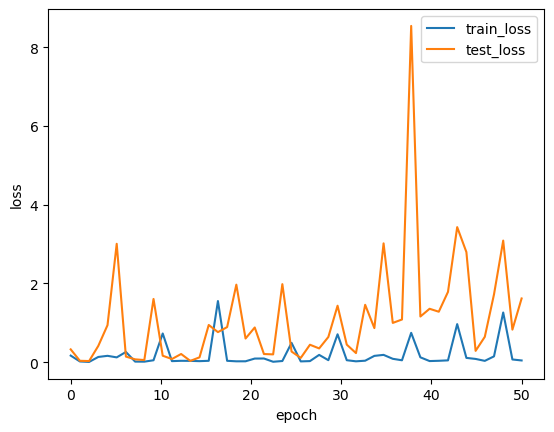

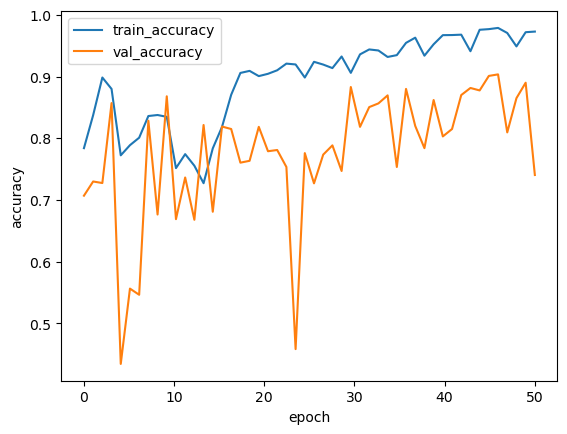

In [15]:
visualization(train_loss,val_loss,train_accuracy,val_accuracy)

In [16]:
test_acc,_ = evaluate_accuracy(test_iter,net,loss)
print("在测试集上的准确率为:%.3f"%(test_acc))

在测试集上的准确率为:0.748
